In [2]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# read in all the names
names = open('names.txt', 'r').read().splitlines()
print('total no. of names', len(names))
names[:8]

total no. of names 32033


['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(names))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(names):  
  X, Y = [], []
  
  for w in names:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(names)
n1 = int(0.8*len(names))
n2 = int(0.9*len(names))

Xtr,  Ytr  = build_dataset(names[:n1])     # 80%
Xdev, Ydev = build_dataset(names[n1:n2])   # 10%
Xte,  Yte  = build_dataset(names[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [7]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g)
b2 = torch.randn(vocab_size,                      generator=g)

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


In [80]:
max_steps = 200000
batch_size = 32
lossi = []
stepi = []

for i in range(max_steps):
    # Forward pass
    ix = torch.randint(low=0, high=Xtr.shape[0], size=(batch_size,), generator=g)        # Constructing mini batch
    Xb, yb = Xtr[ix], Ytr[ix]

    # Forward pass
    emb = C[Xb]     # Embedding the generated words.
    embcat = emb.view(emb.shape[0], emb.shape[1]*emb.shape[2])     # Concatenate the different dimension of words.

    a1 = embcat@W1+b1           # Pre activation
    h1 = torch.tanh(a1)         # tanh activation

    logits = h1@W2+b2
    loss = F.cross_entropy(logits, yb)

    # Backward pass
    for param in parameters:
        param.grad = None

    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    for param in parameters:
        param.data += -lr * param.grad

    # track stats
    #lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())

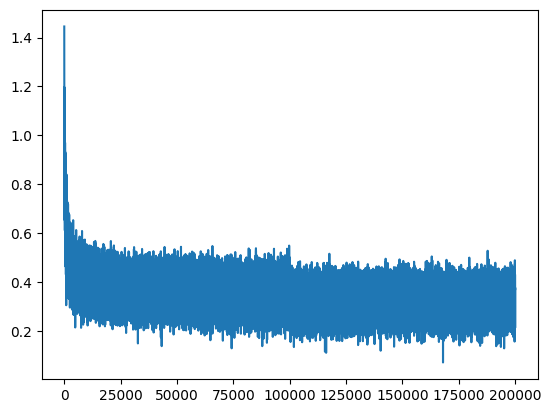

In [81]:
plt.plot(np.arange(len(lossi)), lossi)

In [82]:
print(C[torch.tensor([0, 0, 0])])

tensor([[ 1.6669,  0.3794,  0.1780, -0.4677,  0.3983,  0.1968, -1.5768,  1.2646,
          0.8168,  1.5578],
        [ 1.6669,  0.3794,  0.1780, -0.4677,  0.3983,  0.1968, -1.5768,  1.2646,
          0.8168,  1.5578],
        [ 1.6669,  0.3794,  0.1780, -0.4677,  0.3983,  0.1968, -1.5768,  1.2646,
          0.8168,  1.5578]], grad_fn=<IndexBackward0>)


In [83]:
# Generate new names based on the trained neural network
for i in range(5):
    out_name = []
    context = [0]*block_size

    while True:
        context_tensor = C[torch.tensor([context])]     # (1, block_size, d)
        a1 = context_tensor.view(context_tensor.shape[0], context_tensor.shape[1]*context_tensor.shape[2]) @ W1 + b1
        h1 = torch.tanh(a1)
        logits = h1 @ W2 + b2
        probs = torch.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out_name.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out_name))

vayani.
yus.
brendir.
zaulie.
allah.


In [84]:
W1.shape

torch.Size([30, 200])

# Changes made to the neural network architecture

In [85]:
# To make the neural network more effective, some changes are need to be made.
x = torch.tensor([0, 0, 5, 0], dtype=float)
y = torch.tensor([2])
prob = torch.softmax(x, dim=0)
loss = -prob[y].log()
print(loss.item())

0.020012253359626975


In [86]:
# To make the neural network more effective, some changes are need to be made.
x = torch.tensor([1, 1, 1, 1], dtype=float)
y = torch.tensor([2])
prob = torch.softmax(x, dim=0)
loss = -prob[y].log()
print(loss.item())

1.3862943611198906


In [87]:
# To make the neural network more effective, some changes are need to be made.
x = torch.randn(4)
y = torch.tensor([2])
prob = torch.softmax(x, dim=0)
loss = -prob[y].log()
print('generated tensor', x)
print(loss.item())

generated tensor tensor([-0.1578,  0.6659,  0.0464,  1.0913])
1.8743177652359009


In [138]:
# Improvements
"""
1. Due to random initialization of weight matrices the the loss can be very large. This is because the random initialization fake confident on wrong labels.
    We can start with normalizing the weight matrix W2, by multiplying 0.01. Mean loss --> 0.33101662471264603. This helps in reducing the initial loss value
    but some problem still persists. The histogram of activation function layer h1 has too many values with values around -1 and 1. This is because tanh compresses values
    in the range of -1 and 1.
2. By normalizing the weight matrix W2, we can further minimize the initial loss and number of extremes (-1, 1) in the activation layer will also decrease.
3. If too many activation layer values are between -1 and 1, the gradient at these values are 0 which has no effect on gradient update (as the deirvative at these points are 0s)
    during back propagation. If for a particular neuron, the activation value is -1 or 1 for all training sample, then the neuron becomes a dead neuron ie the neuron doesn't
    change throughout training. This is called a dead neuron problem.
4. If the distribution of the preactivation function values are too broad (high variance) then activation values has too many extremums.
5. Proper initialization of weights (Kaiming Initialization)[https://arxiv.org/abs/1502.01852]. The key idea behind Kaiming initialization is to set the initial weights of the
    neural network in a way that prevents the variance of activations from vanishing or exploding as information passes through the network. It takes into account the non-linearity
    introduced by ReLU(Similar) activation functions. For a given layer with n input units, the weights are initialized by drawing values from a normal distribution with mean 0
    and a standard deviation of gain/sqrt(fan_in). fan_in is the dimension of feature input. The gain value is differetn for differnt non-linearity. For RelU it is sqrt(2)
    and for tanh it is 5/3.
6. Batch Normalization: The insight in batch normalization is to make the pre-activation of the hidden layers into standard gaussian at least at initialization. But we should
    not always force the preactivation into standard gaussian, but want to let the neural network decide to scale and shift during back proagation.[https://arxiv.org/abs/1502.03167].git/
    To keep the scaling (batch normalization gain) and shifting factor (batch normalization bias) a part of the training process, we treat it as a hyperparameter.
    Effects of batch normalization
    - Without batch normalization, each example of a random batch was acting as an single entity in the neural network. The value of a neuron is solely depend upon the input and
    the weight connecting the input and the neuron. Now during batch normalization, we are canculating mean and variance of each batch, and by doing so we are making each example
    of the batch dependent over other. These dependeness cause some kind of regualarization which is beneficial for the stability of neural network. 
    - In real world scenario for a single example, we cannot follow the above process of normalization as it will make the incoming example zero. One way to override the process is
    to use the mean and standard deviation of the entire training example for normalization after the training process was over, particularly for real world scenario where we
    might need to work with single example.
        Another way of doing it is by calculating the mean and std of the whole dataset before training and use it along with the batch mean and std called as running_mean.
        This is implemented below.
"""

'\n1. Normalizing the weight matrices W1 and W2, by multiplying 0.01. Mean loss --> 0.3640873616717756\n2. \n'

In [120]:
# Changing weight initialization to mitigate higher loss at initial epoch.
g = torch.Generator().manual_seed(2147483647)                   # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.01       # Step 1: Normalizing the weight matrix reduces the initial loss and also normalize the activation layer.
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/(3*(n_embd*block_size)**0.5))      # Kaiming Initialization. Step 5.
# Batch normalization. Step 6.
bn_gain = torch.ones((1, n_hidden))       # Has no effect during initialization.
bn_bias = torch.zeros((1, n_hidden))
running_mean = torch.zeros((1, n_hidden))
running_std = torch.ones((1, n_hidden))
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01       # Step 2: 
b2 = torch.randn(vocab_size,                      generator=g) * 0
params = [C, W1, W2, b2, bn_gain, bn_bias]

In [121]:
for p in params:
  p.requires_grad = True

In [122]:
max_steps = 2000
batch_size = 32
lossi = []
stepi = []

for i in range(max_steps):
    # Forward pass
    ix = torch.randint(low=0, high=Xtr.shape[0], size=(batch_size,), generator=g)        # Constructing mini batch
    Xb, yb = Xtr[ix], Ytr[ix]

    # Forward pass
    emb = C[Xb]     # Embedding the generated words.
    embcat = emb.view(emb.shape[0], emb.shape[1]*emb.shape[2])     # Concatenate the different dimension of words.

    a1 = embcat@W1 # + b1           # Pre activation # Addition of the bias term is useless during batch normalizstion.
    
    # Step 6, running mean implementation.
    batch_mean = a1.mean(0, keepdim=True)
    batch_std = (a1.std(0, keepdim=True))

    with torch.no_grad():
        running_mean = 0.999 * running_mean + 0.001 * batch_mean
        running_std = 0.999 * running_std + 0.001 * batch_std

    a1 = bn_gain * ((a1 - running_mean) / running_std) + bn_bias
    h1 = torch.tanh(a1)         # tanh activation

    logits = h1@W2+b2
    loss = F.cross_entropy(logits, yb)

    # Backward pass
    for param in params:
        param.grad = None

    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    for param in params:
        param.data += -lr * param.grad

    # track stats
    #lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())

    if i % 100 == 0:
        print(f'loss at iter {i}: {loss.item()}')

loss at iter 0: 3.3178863525390625
loss at iter 100: 2.4220974445343018
loss at iter 200: 2.6878292560577393
loss at iter 300: 2.8253910541534424
loss at iter 400: 2.498764753341675
loss at iter 500: 2.753596305847168
loss at iter 600: 2.504328727722168
loss at iter 700: 2.4559383392333984
loss at iter 800: 2.310302734375
loss at iter 900: 2.0684776306152344
loss at iter 1000: 2.144228458404541
loss at iter 1100: 2.2480525970458984
loss at iter 1200: 2.584599018096924
loss at iter 1300: 2.659984588623047
loss at iter 1400: 2.287890672683716
loss at iter 1500: 2.3680806159973145
loss at iter 1600: 2.5434272289276123
loss at iter 1700: 2.289207696914673
loss at iter 1800: 2.3053760528564453
loss at iter 1900: 2.3282928466796875


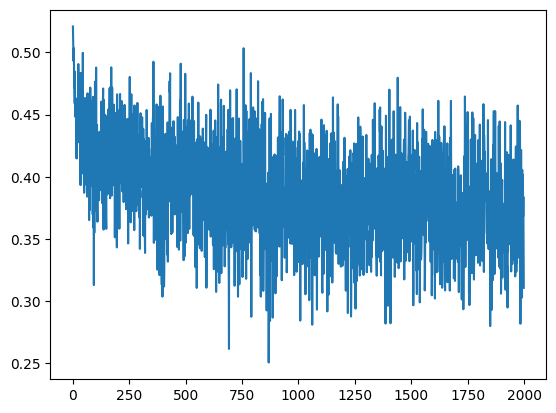

In [123]:
plt.plot(stepi, lossi)
# The loss got improved due to a different initialization.

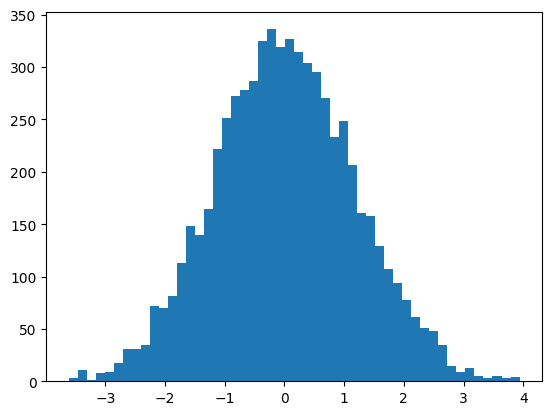

In [124]:
# Plotting the pre activation layer
plt.hist(a1.view(-1).tolist(), bins=50);

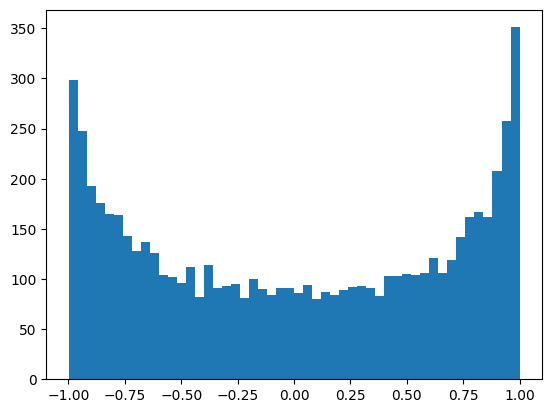

In [125]:
# Plotting the activation layer
plt.hist(h1.view(-1).tolist(), bins=50);

# Combining everything to form a better representation

In [237]:
class Linear:
    """
    Implementation of linear layer in a neural network.
    """
    def __init__(self, fan_in, fan_out, bias=True):
        """
        fan_in : No. of input features.
        fan_out : No. of output features.
        bias : Required bias term. No requiement if batch normalization.
        """
        self.weight = torch.randn((fan_in,  fan_out), generator=g) / (fan_in ** 0.5)
        self.bias = torch.randn(fan_out) if bias else None

    def __call__(self, X):
        self.out = X @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] if self.bias is None else [self.weight, self.bias]

In [238]:
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1, training=True):
        self.eps = eps
        self.momentum = momentum                # Momentum for calculating the running mean and running variance.
        self.training = training                # If normalization is done during training.
        self.gamma = torch.ones((dim, 1))       # The scaling parameter of batch normalization.
        self.beta = torch.zeros((dim, 0))       # The shifting parameter of batch normalization.
        self.running_mean = torch.zeros((dim, 1))
        self.running_var = torch.ones((dim, 1))

    def __call__(self, X):
        # Calculating the forward pass
        if self.training:
            xmean = X.mean(0, keepdims=True)
            xvar = X.var(0, keepdims=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (X-xmean)/(torch.sqrt(xvar)+self.eps)    # Normalize to unit variance.
        self.out = self.gamma * xhat + self.beta

        # Update the buffers (xmean and xvar)
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar

        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

In [239]:
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

In [240]:
n_hidden = 100
n_embd = 10
g = torch.Generator().manual_seed(2147483647)

In [241]:
C = torch.randn((vocab_size, n_embd),   generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size),
]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].weight *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

46497


In [242]:
max_steps = 2000

In [243]:
for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 200 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/   2000: 4.1656
    200/   2000: 2.6150
    400/   2000: 2.6428
    600/   2000: 2.6343
    800/   2000: 2.5023
   1000/   2000: 2.4474
   1200/   2000: 2.5059
   1400/   2000: 2.3795
   1600/   2000: 2.4341
   1800/   2000: 2.0902


layer 1 (Tanh): mean +0.03, std 0.74, saturated: 16.12%
layer 3 (Tanh): mean +0.01, std 0.68, saturated: 7.97%
layer 5 (Tanh): mean +0.02, std 0.69, saturated: 8.53%
layer 7 (Tanh): mean -0.07, std 0.68, saturated: 8.28%
layer 9 (Tanh): mean +0.06, std 0.60, saturated: 6.59%


Text(0.5, 1.0, 'activation distribution')

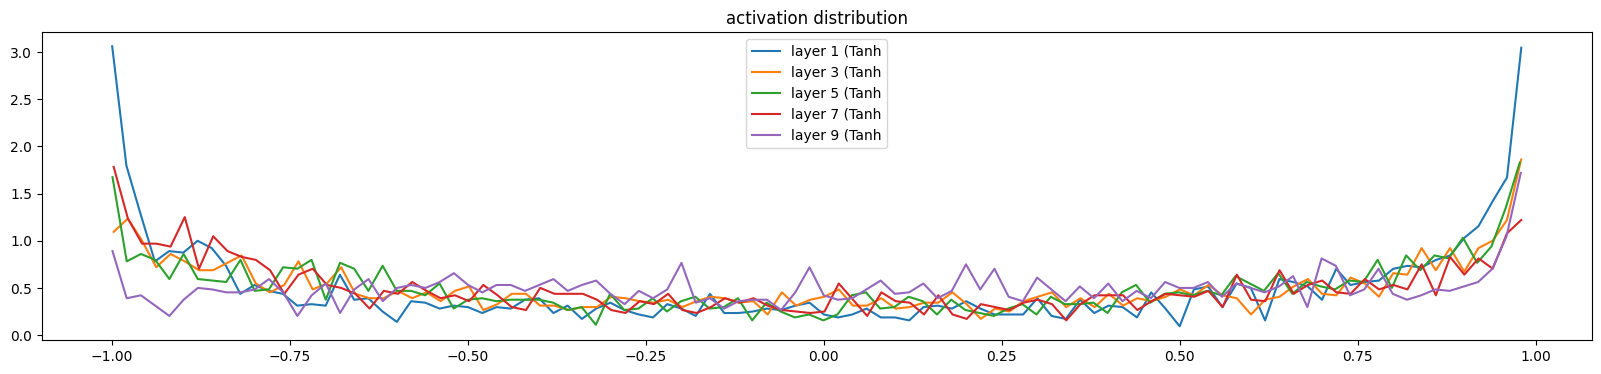

In [244]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):   # isinstance is a internal typechecking in python.
    t = layer.out
    print('layer %d (%2s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 1 (      Tanh): mean -0.000071, std 2.458231e-03
layer 3 (      Tanh): mean +0.000012, std 2.042632e-03
layer 5 (      Tanh): mean +0.000012, std 1.864836e-03
layer 7 (      Tanh): mean -0.000059, std 2.017823e-03
layer 9 (      Tanh): mean +0.000004, std 2.265908e-03


Text(0.5, 1.0, 'gradient distribution')

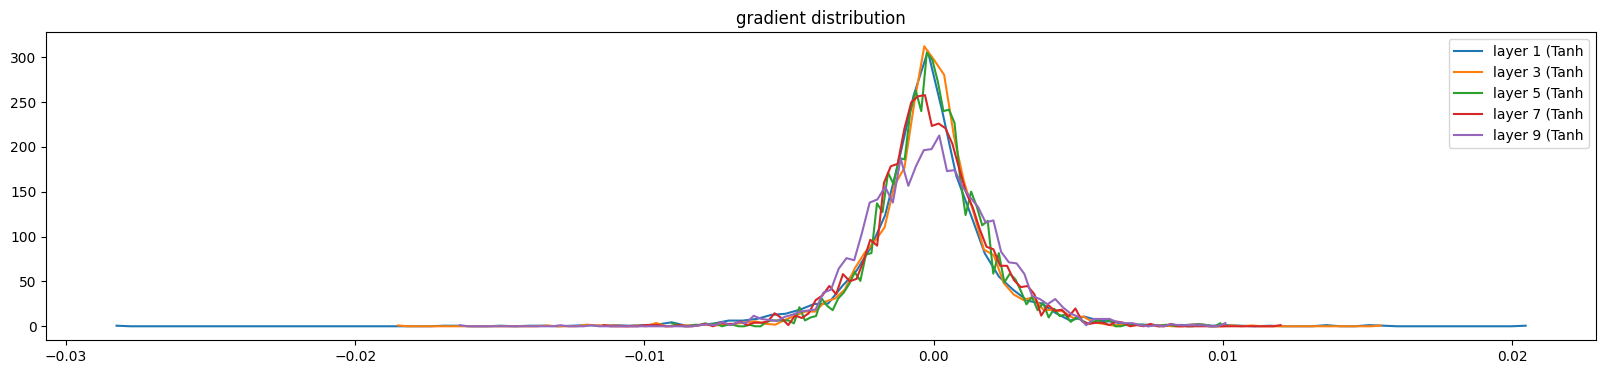

In [245]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')